In [267]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
#print(torch.__version__)
from torch.autograd import Variable
from torch import nn
import torch.nn.init
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim

In [268]:
df = pd.read_excel('thermal-dataset.xlsx', sheet_name ='dataset')
df.head()

,Name,V,M,n,np,B,G,E,v,H,...,Formula,space group,k_BTE_DFT,k_BTE_DFT（1000 K）,k_AFLOW_AAPL,k_AFLOW_AGL,k_AFLOW_AGL (Poisson ratio σ=0.25),k_Mingo,k_EXP,k_EXP（1000 K）
0,66_C,11.41,24.022,2,2,431.7450,518.2490,1110.438653,0.071337,95.902307,...,C (diamond),Fd-3m,NaN,NaN,2270.00,419.90,169.10,NaN,2200/3000,NaN
1,20012_InSb,73.73,236.570,2,2,36.8242,14.5179,38.494849,0.325772,3.219550,...,InSb,F-43m,NaN,NaN,NaN,3.02,3.64,NaN,20/16.5,NaN
2,1190_ZnSe,47.34,144.350,2,2,56.3189,29.0179,74.293904,0.280139,6.603032,...,ZnSe,F-43m,NaN,NaN,NaN,5.44,7.46,NaN,19/33,NaN
3,682_NaF,24.74,41.988,2,2,52.4118,36.3275,88.528881,0.218483,10.653966,...,NaF,Fm-3m,NaN,NaN,21.11,4.67,4.52,NaN,16.5/18.4,NaN
4,16220_Si,40.97,56.170,2,2,90.0009,63.4097,154.050571,0.214724,15.043345,...,Si,Fd-3m,NaN,NaN,144.00,26.19,20.58,NaN,146/166,NaN


In [269]:
df.columns

Index(['Name', 'V', 'M', 'n', 'np', 'B', 'G', 'E', 'v', 'H', 'B'', 'G'', 'ρ',
       'vL', 'vS', 'va', 'Θe', 'γel', 'γes', 'γe', 'A', 'y-exp', 'y-theory',
       'Formula', 'space group', 'k_BTE_DFT', 'k_BTE_DFT（1000 K）',
       'k_AFLOW_AAPL', 'k_AFLOW_AGL', 'k_AFLOW_AGL (Poisson ratio σ=0.25)',
       'k_Mingo', 'k_EXP', 'k_EXP（1000 K）'],
      dtype='object')

In [270]:
df = df.loc[:, :'y-theory']
df.columns

Index(['Name', 'V', 'M', 'n', 'np', 'B', 'G', 'E', 'v', 'H', 'B'', 'G'', 'ρ',
       'vL', 'vS', 'va', 'Θe', 'γel', 'γes', 'γe', 'A', 'y-exp', 'y-theory'],
      dtype='object')

In [271]:
df.describe()

,V,M,n,np,B,G,E,v,H,B',...,vL,vS,va,Θe,γel,γes,γe,A,y-exp,y-theory
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,3.700000e+02,370.000000,370.000000
mean,145.503405,576.941738,6.810811,3.789189,111.257870,59.678087,147.105572,0.296581,10.521358,-6.982807,...,5.385817,2.928926,3.256445,263.253037,1.594866,1.119608,1.995672,9.121067e-05,44.079546,24.255426
std,132.334810,625.505406,4.818313,3.150066,82.433063,77.165080,170.936177,0.083493,14.299973,11.632497,...,2.784979,1.973751,2.152686,225.042124,2.868737,4.816583,3.987999,9.802296e-04,277.377084,49.038768
min,11.410000,8.010000,2.000000,2.000000,7.904080,0.406580,1.215183,0.000656,0.006197,-104.589000,...,1.559351,0.331246,0.379108,25.916963,-7.029521,-65.475244,0.414990,1.459528e-07,0.086000,0.026157
25%,53.210000,157.831500,3.000000,3.000000,47.720850,19.017575,49.639698,0.250683,3.580389,-8.717083,...,3.836785,1.889592,2.115443,144.201287,1.107011,0.624775,0.921418,9.899596e-07,3.887500,4.432038
50%,76.590000,287.557000,5.000000,3.000000,92.003700,44.813700,114.970283,0.303591,7.326539,-2.906780,...,4.836986,2.496888,2.782292,210.531759,1.379069,1.027563,1.199428,1.864054e-06,11.075000,12.781238
75%,219.020000,907.187000,12.000000,3.000000,160.493000,67.233975,175.339469,0.344524,11.691259,-1.296300,...,5.826099,3.203630,3.595112,281.975073,1.606329,1.373321,1.597086,3.706014e-06,23.082500,22.402090
max,995.000000,5168.290000,29.000000,29.000000,434.165000,523.852000,1120.785827,0.494396,106.084131,29.742400,...,18.019141,12.254442,13.361204,1755.800206,51.169090,47.244050,53.566903,1.670399e-02,5200.000000,547.103092


In [272]:
df.shape

(370, 23)

In [273]:
df.isna().sum()

Name        0
V           0
M           0
n           0
np          0
B           0
G           0
E           0
v           0
H           0
B'          0
G'          0
ρ           0
vL          0
vS          0
va          0
Θe          0
γel         0
γes         0
γe          0
A           0
y-exp       0
y-theory    0
dtype: int64

In [274]:
print(len(df.n.unique()))
print(len(df.np.unique()))

15
15


In [275]:
#Replacing "n"
X = df.loc[:, ['n']]
y = df['y-exp']
OHEncoder = ce.OneHotEncoder(cols = ['n'])
newCols = OHEncoder.fit_transform(X, y)
df = df.drop(['n'], axis = 1)
df = df.join(newCols)

#Replacing "np"
X = df.loc[:, ['np']]
y = df['y-exp']
OHEncoder = ce.OneHotEncoder(cols = ['np'])
newCols = OHEncoder.fit_transform(X, y)
df = df.drop(['np'], axis = 1)
df = df.join(newCols)

/home/sadman/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [276]:
df.columns, df.columns.shape

(Index(['Name', 'V', 'M', 'B', 'G', 'E', 'v', 'H', 'B'', 'G'', 'ρ', 'vL', 'vS',
        'va', 'Θe', 'γel', 'γes', 'γe', 'A', 'y-exp', 'y-theory', 'n_1', 'n_2',
        'n_3', 'n_4', 'n_5', 'n_6', 'n_7', 'n_8', 'n_9', 'n_10', 'n_11', 'n_12',
        'n_13', 'n_14', 'n_15', 'np_1', 'np_2', 'np_3', 'np_4', 'np_5', 'np_6',
        'np_7', 'np_8', 'np_9', 'np_10', 'np_11', 'np_12', 'np_13', 'np_14',
        'np_15'],
       dtype='object'),
 (51,))

In [277]:
y_theory = df['y-theory'].values
df = df.drop(columns=['y-theory'])
y_theory

array([5.47103092e+02, 4.34409393e+00, 8.83552653e+00, 1.76556363e+01,
       4.08157516e+01, 3.04336639e+01, 1.16520522e+01, 4.06207592e+01,
       6.14393581e+01, 1.46431122e+02, 1.30123539e+02, 4.01184072e+01,
       3.43295845e+02, 2.66374859e+01, 2.05159539e+01, 2.65594241e+02,
       2.22351199e+02, 2.31233787e+02, 1.92571258e+01, 1.79763713e+02,
       1.67790030e+02, 1.78481073e+02, 1.40004820e+02, 2.24286312e+01,
       1.71740875e+02, 1.64527923e+02, 1.51845435e+02, 1.67923922e+02,
       2.37071428e+01, 1.66205902e+02, 2.03897001e+02, 1.92243680e+02,
       2.49756459e+01, 1.72200844e+01, 1.87350480e+01, 1.16504218e+01,
       2.54374342e+01, 2.02139390e+01, 2.24774423e+01, 1.20080075e+02,
       2.47966820e+01, 8.79382272e+01, 3.49949208e+01, 1.09468699e+01,
       1.25784369e-01, 2.20510643e+01, 3.12421349e+00, 1.97465160e+01,
       1.90527938e+01, 1.91718068e+00, 2.39450091e+01, 9.73866313e+00,
       3.03845914e+01, 3.20414393e+01, 3.89541097e+01, 8.96149223e+00,
      

In [278]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [279]:
class NeurNet(nn.Module):
    def __init__(self):
        super(NeurNet, self).__init__()
        
        self.linearXto1024 = nn.Sequential(
            nn.Linear(49, 1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.linear1024to1024 = nn.Sequential(
            nn.Linear(1024, 1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.linear1024to512 = nn.Sequential(
            nn.Linear(1024, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        self.linear512to512 = nn.Sequential(
            nn.Linear(512, 512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        self.linear512to256 = nn.Sequential(
            nn.Linear(512, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        self.linear256to256 = nn.Sequential(
            nn.Linear(256, 256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        self.linear256to128 = nn.Sequential(
            nn.Linear(256, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        self.linear128to128 = nn.Sequential(
            nn.Linear(128, 128, bias=True),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        self.linear128to64 = nn.Sequential(
            nn.Linear(128, 64, bias=True),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        self.linear64to64 = nn.Sequential(
            nn.Linear(64, 64, bias=True),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        self.linear64to32 = nn.Sequential(
            nn.Linear(64, 32, bias=True),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        
        self.linear32to32 = nn.Sequential(
            nn.Linear(32, 32, bias=True),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        
        self.linear32to1 = nn.Linear(32, 1, bias=True)
        
        self.projectionXto1024 = nn.Linear(49, 1024, bias=True)
        self.projection1024to512 = nn.Linear(1024, 512, bias=True)
        self.projection512to256 = nn.Linear(512, 256, bias=True)
        self.projection256to128 = nn.Linear(256, 128, bias=True)
        self.projection128to64 = nn.Linear(128, 64, bias=True)
        self.projection64to32 = nn.Linear(64, 32, bias=True)
        
    def forward(self, x):
        outPrev = x
        
        out = self.linearXto1024(x)
        out = torch.add(out, self.projectionXto1024(outPrev))
        outPrev = out
        
        out = self.linear1024to1024(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear1024to1024(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear1024to1024(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear1024to512(out)
        out = torch.add(out, self.projection1024to512(outPrev))
        outPrev = out
        
        out = self.linear512to512(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear512to512(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear512to256(out)
        out = torch.add(out, self.projection512to256(outPrev))
        outPrev = out
        
        out = self.linear256to256(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear256to256(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear256to128(out)
        out = torch.add(out, self.projection256to128(outPrev))
        outPrev = out
        
        out = self.linear128to128(out)
        out = torch.add(out, outPrev)
        outPrev = out
        out = self.linear128to128(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear128to64(out)
        out = torch.add(out, self.projection128to64(outPrev))
        outPrev = out
        
        out = self.linear64to64(out)
        out = torch.add(out, outPrev)
        outPrev = out
        
        out = self.linear64to32(out)
        out = torch.add(out, self.projection64to32(outPrev))
        
        out = self.linear32to1(out)
        
        return out
    
#neurnet = NeurNet().to(device)

In [280]:
# for name, param in neurnet.state_dict().items():
#     print(name, param.size())

In [290]:
num_epochs = 500
learning_rate = 0.001
criterion = nn.MSELoss()

In [291]:
# print('Results on training set using 17 layer NeurNet after %d iterations:\n------------------------------'%(num_epochs))
# print('r2 score: ', r2_score(y_train.cpu().detach().numpy(), final_output_train.cpu().detach().numpy()))
# print('Mean Absolute Error:', criterion(final_output_train, y_train.float()).cpu().detach().numpy())
# print('Mean Squared Error: ', mean_squared_error(y_train.cpu().detach().numpy(), final_output_train.cpu().detach().numpy()))
# print('Root mean squared error: ', np.sqrt(mean_squared_error(y_train.cpu().detach().numpy(), final_output_train.cpu().detach().numpy())))

In [297]:
losses_train = []
losses_val = []
epochs = np.arange(1, num_epochs + 1)
final_output_test = torch.Tensor(55, 1)
cv_error_mse = []
cv_error_rmse = []
for r in range(10):
    neurnet = NeurNet().to(device)
    optimizer = torch.optim.Adam(neurnet.parameters(), lr=learning_rate)
    
    minLoss = 1000000000000.0
    
    train, test = train_test_split(df, test_size=0.25, random_state=r*2, shuffle=True)
    test, val = train_test_split(test, test_size=0.4, random_state=r*2, shuffle=True)
    
    y_train = train['y-exp'].values
    excluded_columns = ["Name"]
    X_train = train.drop(excluded_columns, axis=1)

    y_test = test['y-exp'].values
    excluded_columns = ["Name"]
    X_test = test.drop(excluded_columns, axis=1)

    y_val = test['y-exp'].values
    excluded_columns = ["Name"]
    X_val = test.drop(excluded_columns, axis=1)
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    y_val = torch.from_numpy(y_val)
    #y_train = y_train.view(y_train.shape[0], 1)
    y_test = y_test.view(y_test.shape[0], 1)
    y_val = y_val.view(y_val.shape[0], 1)
    
    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    X_val = torch.from_numpy(X_val)
    
    train_dataset = Data.TensorDataset(X_train, y_train)
    train_loader = Data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=1)
    
    #X_train = Variable(X_train).to(device)
    X_test = Variable(X_test).to(device)
    X_val = Variable(X_val).to(device)
    #y_train = Variable(y_train).to(device)
    y_test = Variable(y_test).to(device)
    y_val = Variable(y_val).to(device)
    
    print(f'Run-{r + 1}:\n----------')
    
    for epoch in range(num_epochs):
        for i, (batch_X, batch_y) in enumerate(train_loader):
            #print(batch_X, batch_y)
            optimizer.zero_grad()

            Xtor = Variable(batch_X).to(device)
            ytor = Variable(batch_y.view(batch_y.shape[0], 1)).to(device)
            #print(Xtor.shape, ytor.shape)

            outputs = neurnet(Xtor.float())
            val_outputs = neurnet(X_val.float())

            loss = criterion(outputs, ytor.float())
            val_loss = criterion(val_outputs, y_val.float())
            loss.backward()
            optimizer.step()

        print('Epoch [%d/%d], Train loss: %.4f, Validation loss: %.4f'
             %(epoch+1, num_epochs, loss.data, val_loss.data))
        
        if r == 0:
            losses_train.append(loss)
            losses_val.append(val_loss)

        if val_loss.data < minLoss:
            minLoss = val_loss.data
            #print('%.4f'%(minLoss))
            final_output_test = neurnet(X_test.float())

    print('lowest validation error achieved : %.4f'%(minLoss))
    test_mse = mean_squared_error(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy())
    cv_error_mse.append(test_mse)
    cv_error_rmse.append(np.sqrt(test_mse))
    print('test error: ', test_mse)
    print('')
print("\nCV MSE : ", np.mean(cv_error_mse))
print("CV RMSE : ", np.mean(cv_error_rmse))

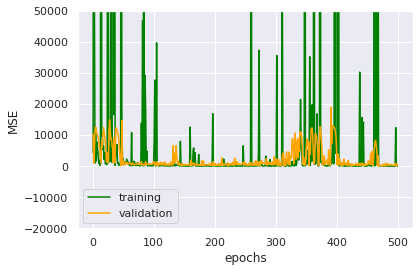

In [284]:
for i in range(len(losses_train)):
    losses_train[i] = losses_train[i].cpu().detach().numpy()
    losses_val[i] = losses_val[i].cpu().detach().numpy()
plt.plot(epochs, losses_train, color='green', label='training')
plt.plot(epochs, losses_val, color='orange', label='validation')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.ylim(-2e4, 0.05e6)
plt.show()

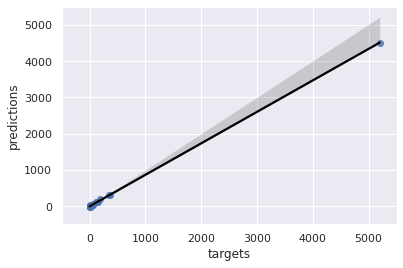

In [288]:
fig = plt.figure()
sns.set_theme(color_codes=True)
ax = sns.regplot(x=y_test.cpu().detach().numpy(), y=final_output_test.cpu().detach().numpy(), line_kws={"color": "black"})
plt.xlabel('targets')
plt.ylabel('predictions')
plt.xlim(-500, 5500)
plt.ylim(-500, 5500)
plt.show()

In [296]:
r2_score(y_test.cpu().detach().numpy(), final_output_test.cpu().detach().numpy())

0.9924491655353419

In [300]:
# #--------------y-theory results (mse)-----------------
# excluded_columns = ["Name"]
# X_theory = df.drop(excluded_columns, axis=1)
# scaler = RobustScaler()
# X_theory = scaler.fit_transform(X_theory)
# X_theory = torch.from_numpy(X_theory)
# final_output_theory = neurnet(X_theory.float())
# mean_squared_error(y_theory, final_output_theory.cpu().detach().numpy())

In [305]:
num_epochs = 300
learning_rate = 0.001
criterion = nn.L1Loss()
#criterion = nn.MSELoss()

In [313]:
losses_train_mae = []
losses_val_mae = []
epochs = np.arange(1, num_epochs + 1)
final_output_test_mae = torch.Tensor(55, 1)
cv_error_mae = []
for r in range(1): #run according to the number of cv-folds
    neurnet = NeurNet().to(device)
    optimizer = torch.optim.Adam(neurnet.parameters(), lr=learning_rate)
    
    minLoss = 1000000000000.0
    
    train, test = train_test_split(df, test_size=0.25, random_state=r*2, shuffle=True)
    test, val = train_test_split(test, test_size=0.4, random_state=r*2, shuffle=True)
    
    y_train = train['y-exp'].values
    excluded_columns = ["Name"]
    X_train = train.drop(excluded_columns, axis=1)

    y_test = test['y-exp'].values
    excluded_columns = ["Name"]
    X_test = test.drop(excluded_columns, axis=1)

    y_val = test['y-exp'].values
    excluded_columns = ["Name"]
    X_val = test.drop(excluded_columns, axis=1)
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    y_val = torch.from_numpy(y_val)
    #y_train = y_train.view(y_train.shape[0], 1)
    y_test = y_test.view(y_test.shape[0], 1)
    y_val = y_val.view(y_val.shape[0], 1)
    
    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    X_val = torch.from_numpy(X_val)
    
    train_dataset = Data.TensorDataset(X_train, y_train)
    train_loader = Data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=1)
    
    #X_train = Variable(X_train).to(device)
    X_test = Variable(X_test).to(device)
    X_val = Variable(X_val).to(device)
    #y_train = Variable(y_train).to(device)
    y_test = Variable(y_test).to(device)
    y_val = Variable(y_val).to(device)
    
    print(f'Run-{r + 1}:\n----------')
    
    for epoch in range(num_epochs):
        for i, (batch_X, batch_y) in enumerate(train_loader):
            #print(batch_X, batch_y)
            optimizer.zero_grad()

            Xtor = Variable(batch_X).to(device)
            ytor = Variable(batch_y.view(batch_y.shape[0], 1)).to(device)
            #print(Xtor.shape, ytor.shape)

            outputs = neurnet(Xtor.float())
            val_outputs = neurnet(X_val.float())

            loss = criterion(outputs, ytor.float())
            val_loss = criterion(val_outputs, y_val.float())
            loss.backward()
            optimizer.step()

        print('Epoch [%d/%d], Train loss: %.4f, Validation loss: %.4f'
             %(epoch+1, num_epochs, loss.data, val_loss.data))
        
        if r == 0:
            losses_train_mae.append(loss)
            losses_val_mae.append(val_loss)

        if val_loss.data < minLoss:
            minLoss = val_loss.data
            #print('%.4f'%(minLoss))
            final_output_test_mae = neurnet(X_test.float())

    print('lowest validation error achieved : %.4f'%(minLoss))
    test_mae = criterion(final_output_test_mae, y_test.float()).cpu().detach().numpy()
    cv_error_mae.append(test_mae)
    print('test error: ', test_mae)
print("\nCV MAE : ", np.mean(cv_error_mae))

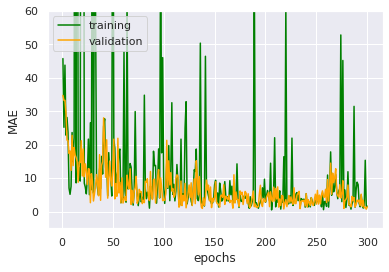

In [314]:
for i in range(len(losses_train_mae)):
    losses_train_mae[i] = losses_train_mae[i].cpu().detach().numpy()
    losses_val_mae[i] = losses_val_mae[i].cpu().detach().numpy()
plt.plot(epochs, losses_train_mae, color='green', label='training')
plt.plot(epochs, losses_val_mae, color='orange', label='validation')
plt.xlabel('epochs')
plt.ylabel('MAE')
plt.ylim(-5, 60)
plt.legend()
plt.show()

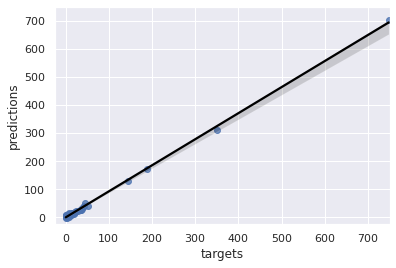

In [320]:
fig = plt.figure()
sns.set_theme(color_codes=True)
ax = sns.regplot(x=y_test.cpu().detach().numpy(), y=final_output_test.cpu().detach().numpy(), line_kws={"color": "black"})
plt.xlabel('targets')
plt.ylabel('predictions')
plt.xlim(-25, 750)
plt.ylim(-25, 750)
plt.show()

In [330]:
#--------------y-theory results (mae)-----------------
# excluded_columns = ["Name"]
# X_theory = df.drop(excluded_columns, axis=1)
# scaler = RobustScaler()
# X_theory = scaler.fit_transform(X_theory)
# X_theory = torch.from_numpy(X_theory)
# final_output_theory = neurnet(X_theory.float())
# y_theory = torch.from_numpy(y_theory)
# criterion(y_theory.float(), final_output_theory).cpu().detach().numpy()

/home/sadman/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([370, 1])) that is different to the input size (torch.Size([370])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


array(49.644104, dtype=float32)

In [332]:
#--------------y-theory results (r2 score)-----------------
# excluded_columns = ["Name"]
# X_theory = df.drop(excluded_columns, axis=1)
# scaler = RobustScaler()
# X_theory = scaler.fit_transform(X_theory)
# X_theory = torch.from_numpy(X_theory)
# final_output_theory = neurnet(X_theory.float())
# #y_theory = torch.from_numpy(y_theory)
# r2_score(y_theory.cpu().detach().numpy(), final_output_theory.cpu().detach().numpy())